In [27]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

load_dotenv()
hist_url = os.getenv('HISTORICAL_URL')

In [28]:
def fetch_upstox_data(hist_url, instrument, unit, interval, to_date, from_date):
    """
    Fetch historical candle data from Upstox API.
    Args:
        instrument (str): Instrument identifier.
        unit (str): Time unit (e.g., 'minutes', 'hours').
        interval (str): Interval for the data.
        to_date (str): End date for the data in 'YYYY-MM-DD' format.
        from_date (str): Start date for the data in 'YYYY-MM-DD' format.
    """
    if not hist_url:
        print("HISTORICAL_URL is not set in the environment variables.")
        return
    
    url = f'{hist_url}/historical-candle/{instrument}/{unit}/{interval}/{to_date}/{from_date}'
    headers = {
    'Accept': 'application/json'
    }

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if 'data' in data and 'candles' in data['data']:
            candles = data['data']['candles']
            columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'open_interest']
            df = pd.DataFrame(candles, columns=columns)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df.set_index('timestamp', inplace=True)
    else:
        print(f"Error fetching data: {instrument} - {response.status_code} - {response.text}")
        return None
    return df

In [29]:
def fetch_nifty50_data(hist_url, unit='minutes', interval='1', to_date='2025-06-27', from_date='2025-05-28'):
    """
    Fetch historical candle data for all Nifty 50 stocks from Upstox API.
    Args:
        hist_url (str): Base URL for the Upstox historical data API.
        unit (str): Time unit (e.g., 'minutes', 'hours').
        interval (str): Interval for the data.
        to_date (str): End date for the data in 'YYYY-MM-DD' format.
        from_date (str): Start date for the data in 'YYYY-MM-DD' format.
    """
    # Load NIFTY50 instruments from CSV and fetch data for each
    nifty50_df = pd.read_csv('../../data/processed/NIFTY50.csv')
    instrument_keys = nifty50_df['instrument_key'].tolist()

    dfs = []
    for instrument in instrument_keys:
        temp_df = fetch_upstox_data(hist_url, instrument, unit, interval, to_date, from_date)
        if temp_df is not None:
            dfs.append(temp_df)
            print(f"Fetched data for {instrument}.")
        else:
            print(f"Failed to fetch data for {instrument}.")

    print(f"Fetched data for {len(dfs)} instruments.")
    return dfs

In [30]:
def plot_candlestick(df):
    """
    Plot a candlestick chart from the DataFrame, skipping non-trading periods for a continuous look.
    Args:
        df (pd.DataFrame): DataFrame containing the historical data.
    """
    if df.empty:
        print("DataFrame is empty. No data to plot.")
        return

    # Reset index to get sequential integer x-axis (removes gaps for non-trading times)
    df_reset = df.reset_index()
    x = range(len(df_reset))

    fig, ax = plt.subplots(figsize=(12, 6))

    for i in x:
        color = 'green' if df_reset['close'].iloc[i] >= df_reset['open'].iloc[i] else 'red'
        # High-low line
        ax.plot([i, i], [df_reset['low'].iloc[i], df_reset['high'].iloc[i]], color=color)
        # Candle body
        ax.add_patch(plt.Rectangle(
            (i - 0.3, min(df_reset['open'].iloc[i], df_reset['close'].iloc[i])),
            0.6,
            abs(df_reset['open'].iloc[i] - df_reset['close'].iloc[i]),
            color=color
        ))

    # Set x-ticks to show some timestamps for reference
    step = max(1, len(df_reset) // 10)
    ax.set_xticks(x[::step])
    ax.set_xticklabels(df_reset['timestamp'].dt.strftime('%Y-%m-%d %H:%M')[::step], rotation=45, ha='right')

    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Candlestick Chart (Continuous Trading Sessions)')
    plt.tight_layout()
    plt.show()

In [31]:
# instrument = 'NSE_EQ%7CINE848E01016'
unit = 'minutes'
interval = '1'
to_date = '2025-06-27'
from_date = '2025-05-28'

dfs = fetch_nifty50_data(hist_url, unit, interval, to_date, from_date)

Fetched data for NSE_EQ|INE423A01024.
Fetched data for NSE_EQ|INE437A01024.
Fetched data for NSE_EQ|INE021A01026.
Fetched data for NSE_EQ|INE296A01032.
Fetched data for NSE_EQ|INE263A01024.
Fetched data for NSE_EQ|INE795G01014.
Fetched data for NSE_EQ|INE059A01026.
Fetched data for NSE_EQ|INE089A01031.
Fetched data for NSE_EQ|INE066A01021.
Fetched data for NSE_EQ|INE047A01021.
Fetched data for NSE_EQ|INE040A01034.
Fetched data for NSE_EQ|INE158A01026.
Fetched data for NSE_EQ|INE038A01020.
Fetched data for NSE_EQ|INE030A01027.
Fetched data for NSE_EQ|INE009A01021.
Fetched data for NSE_EQ|INE154A01025.
Fetched data for NSE_EQ|INE237A01028.
Fetched data for NSE_EQ|INE849A01020.
Fetched data for NSE_EQ|INE101A01026.
Fetched data for NSE_EQ|INE213A01029.
Fetched data for NSE_EQ|INE002A01018.
Fetched data for NSE_EQ|INE062A01020.
Fetched data for NSE_EQ|INE044A01036.
Fetched data for NSE_EQ|INE192A01025.
Fetched data for NSE_EQ|INE155A01022.
Fetched data for NSE_EQ|INE081A01020.
Fetched data

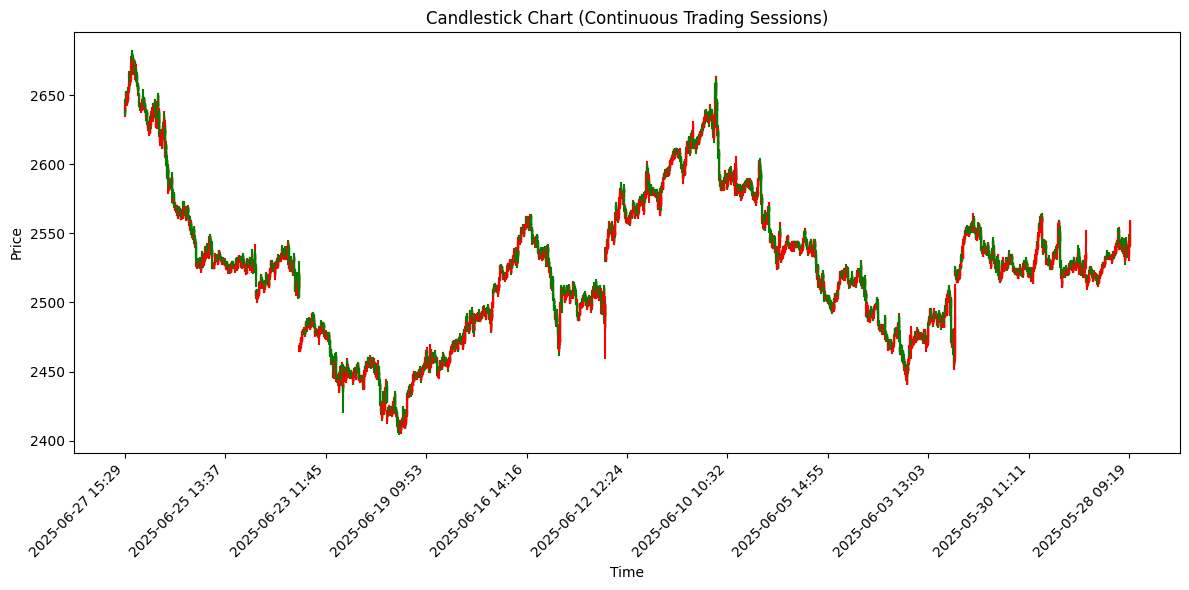

In [32]:
if dfs:
    plot_candlestick(dfs[0])  # Plotting the first DataFrame as an example

In [33]:
print(dfs[0].head() if dfs else "No data fetched.")

                             open    high     low   close  volume  \
timestamp                                                           
2025-06-27 15:29:00+05:30  2636.3  2645.0  2635.6  2644.8    4464   
2025-06-27 15:28:00+05:30  2639.7  2639.7  2635.0  2638.3    8692   
2025-06-27 15:27:00+05:30  2638.8  2640.0  2636.5  2639.8    5925   
2025-06-27 15:26:00+05:30  2640.1  2640.7  2638.4  2639.8    4917   
2025-06-27 15:25:00+05:30  2640.0  2641.5  2637.5  2640.1    7235   

                           open_interest  
timestamp                                 
2025-06-27 15:29:00+05:30              0  
2025-06-27 15:28:00+05:30              0  
2025-06-27 15:27:00+05:30              0  
2025-06-27 15:26:00+05:30              0  
2025-06-27 15:25:00+05:30              0  


In [ ]:
nifty50_df = pd.read_csv('../../data/processed/NIFTY50.csv')
symbols = nifty50_df['tradingsymbol'].tolist()

for index, symbol in enumerate(symbols):
    df = dfs[index] if index < len(dfs) else None
    if df is not None:
        df.to_csv(f'../../data/raw/NIFTY50_OHLCV/{symbol}.csv')
        print(f"Saved data for {symbol} to CSV.")
    else:
        print(f"Failed to save data for {symbol}.")

Saved data for ADANIENT to CSV.
Saved data for APOLLOHOSP to CSV.
Saved data for ASIANPAINT to CSV.
Saved data for BAJFINANCE to CSV.
Saved data for BEL to CSV.
Saved data for HDFCLIFE to CSV.
Saved data for CIPLA to CSV.
Saved data for DRREDDY to CSV.
Saved data for EICHERMOT to CSV.
Saved data for GRASIM to CSV.
Saved data for HDFCBANK to CSV.
Saved data for HEROMOTOCO to CSV.
Saved data for HINDALCO to CSV.
Saved data for HINDUNILVR to CSV.
Saved data for INFY to CSV.
Saved data for ITC to CSV.
Saved data for KOTAKBANK to CSV.
Saved data for TRENT to CSV.
Saved data for M&M to CSV.
Saved data for ONGC to CSV.
Saved data for RELIANCE to CSV.
Saved data for SBIN to CSV.
Saved data for SUNPHARMA to CSV.
Saved data for TATACONSUM to CSV.
Saved data for TATAMOTORS to CSV.
Saved data for TATASTEEL to CSV.
Saved data for TITAN to CSV.
Saved data for WIPRO to CSV.
Saved data for SHRIRAMFIN to CSV.
Saved data for ICICIBANK to CSV.
Saved data for ETERNAL to CSV.
Saved data for INDUSINDBK to C